In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.distributions.log_normal import LogNormal
from scipy.special import erfinv
from Helper.ImportDatasets import df_epsilon, df_epsilon_crit
from Method.calculate_distribution_a import distribution_a


# Check how mu and s relate

In [6]:
thetas = torch.tensor([[1, 1.1, 0.9], [0.1, 0.2, 0.3]])
D = torch.tensor([5, 6, 7, 8, 9])

distr = torch.distributions.log_normal.LogNormal(thetas[0], thetas[1])
vals = distr.cdf(D[:, None])

def calculate_s(a, sigma, mu):
    return (np.log(a)-mu)/(erfinv(2*sigma - 1)*np.sqrt(2))

Text(0, 0.5, 's')

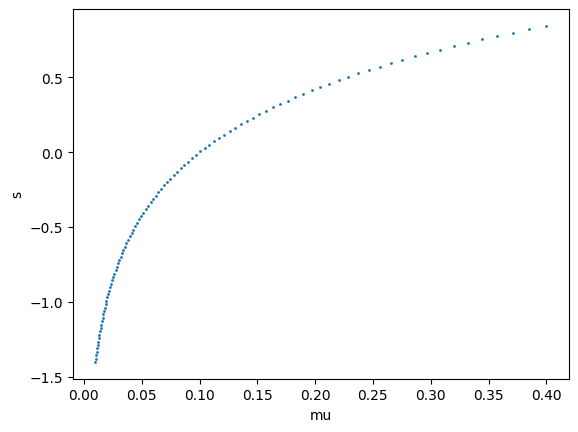

In [7]:
mu_upper = np.log(0.4)
mu_lower = np.log(0.01)

plt.scatter(np.exp(np.linspace(mu_lower, mu_upper, 100)), calculate_s(0.1, 0.05, np.linspace(mu_lower, mu_upper, 100)), s = 1)
plt.xlabel('mu')
plt.ylabel('s')

# Basically at np.log(a) = mu, s = 0, so we can sample uniformly from np.log(a) to mu_upper

# Calculate distributions of a

In [4]:
def integrand(thetas, D):
    """
    value under integrand without prior, so integral( val * prior )
    currently prior is uniform so it doesn't matter, it would also not matter if it werent as then we just sample using MCMC and it would turn out the same
    
    :param thetas: Sampled parameters to try, 2x... tensor, first row is mus, second row is sigmas
    :param D: Data of epsilons, 2xN tensor, first row is lower bounds, second row is upper bounds
    :return: Likelihoods (val's under integral), a tensor of size thetas.shape[1:], for each theta we have a value
    """
    # For broadcasting of thetas and D we add a dimension to thetas at the end
    thetas = thetas[...,None]
    # thetas is a 2x... tensor, first row is mus, second row is sigmas
    distributions = LogNormal(thetas[0], thetas[1])
    # D is a 2xN tensor, first row is lower bounds, second row is upper bounds
    vals = distributions.cdf(D[0]) - distributions.cdf(D[1])
    # Likelihoods is a tensor of size thetas.shape[1:], for each theta we have a value
    # We aggregate over the last dimension (size N) which is the dimension of D
    Likelihoods = vals.prod(dim = -1)
    return Likelihoods

In [117]:
def calculate_s(a, sigma, mu):
    return (torch.log(a)-mu)/(torch.erfinv(2*torch.tensor([sigma]) - 1)*np.sqrt(2))

# We perform monte carlo integration for the integral
def distribution_a(a,D,sigma,n_samples):
    """
    We want to find the probability of a given D, to forego computing the integral we use monte carlo integration.
    Since our prior is unigorm for now we just sample uniformly. NOTE: it will be normalized over the range of a which has been given as input
    
    :param a: a values to query, tensor of size M
    :param D: Data of epsilons, 2xN tensor, first row is lower bounds, second row is upper bounds
    :return: 
    """
    # Median of log normal is exp(mu), thus we want to sample exp(mu) uniformly from 0 to 0.4
    # We have seen that mu > log(a) otherwise we cannot get cdf(a) = sigma, thus that is our lower bound
    mu_upper = np.log(0.4)
    mus = torch.rand(n_samples, a.shape[0]) * (mu_upper - torch.log(a+0.001)) + torch.log(a+0.001)

    ss = calculate_s(a, sigma, mus)
    thetas = torch.stack([mus, ss])
    
    # Monte carlo integration
    integral_approximation = torch.mean(integrand(thetas, D),dim = 0)
    
    # Normalization
    return integral_approximation/integral_approximation.sum()
    
    

In [21]:
import matplotlib.animation as animation
"""
We pick sigma, delta, network and number of samples. Although delta doesn't matter much as the region of a we use is large enough to quickly find a solution where prob = 1
"""
def run(network):
    sigma = 0.05
    delta = 0.05
    n_samples = 10000
    
    # Get the network and test set, then split the images
    df_for_network = df_epsilon[df_epsilon['network'] == network]
    df_for_network = df_for_network[df_for_network['ds'] == 'test']
    df_per_image = [df_for_network[df_for_network['image'] == i] for i in df_for_network['image'].unique()]
    
    # We find the distribution of 'a' for the following values
    a = torch.linspace(0.001,0.399,200)
    
    # We keep track of the distributions of 'a' and its max probability
    distributions_of_a = []
    max_prob = []
    
    # Initialize D (dataset) and the default value to put in if we don't find elligible epsilons
    D = torch.tensor([[],[]],dtype=torch.float32)
    default = torch.tensor([[0.001],[0.4]],dtype=torch.float32)
    for i,image in enumerate(df_per_image):
        # We put in the default value first and then change it to the lower and upper bound of the image
        D = torch.cat((D,default),dim=1)
        
        # unsat means epsilon >, thus lower bound
        lower_bound = np.max(image[image['result']=='unsat']['epsilon'].values)
        # sat means epsilon <, thus upper bound
        upper_bound = np.min(image[image['result']=='sat']['epsilon'].values)
        D[0,-1] = lower_bound
        D[1,-1] = upper_bound
        
        print(f"image {i+1}")
        
        # We calculate the distribution of 'a'
        distr = distribution_a(a,D,sigma,n_samples)
        max_distr = torch.max(distr)
        distributions_of_a.append(distr)
        max_prob.append(max_distr)
        
        # We check if we have attained a probability of at least 1-delta
        if max_distr > 1-delta:
            print('found')
            break
        
        # Most likely the above will not happen but the distribution of 'a' will become too peaked to fit in the range of a that has been given
        # In that case we are also satisfied as we know 'a' is in a small enough region
        if torch.isnan(max_distr):
            distributions_of_a.pop()
            max_prob.pop()
            print('found: region is too small')
            break
    
    fig, ax = plt.subplots()

    ax.set_ylim(0, 1)
    line, = ax.plot(a, np.tile(0,len(a)))
    
    
    def animate(i):
        line.set_ydata(distributions_of_a[i])  # update the data.
        return line,
    
    
    ani = animation.FuncAnimation(
        fig, animate, frames=len(distributions_of_a), interval=20, blit=True, save_count=50)
    
    # To save the animation, use e.g.
    #
    ani.save(network+".gif")

MovieWriter ffmpeg unavailable; using Pillow instead.


IndexError: list index out of range

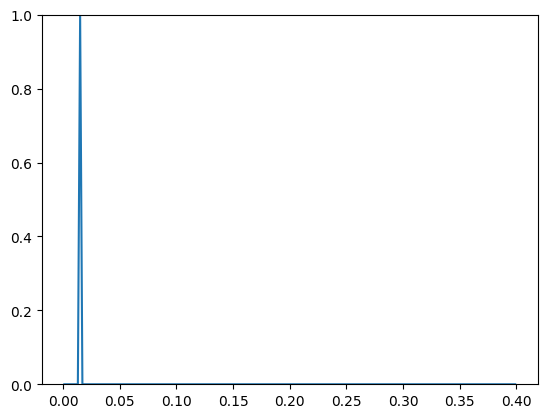

In [14]:
# Save as animation
import matplotlib.animation as animation

fig, ax = plt.subplots()

ax.set_ylim(0, 1)
line, = ax.plot(a, np.tile(0,len(a)))


def animate(i):
    line.set_ydata(distributions_of_a[i])  # update the data.
    return line,


ani = animation.FuncAnimation(
    fig, animate, frames=len(distributions_of_a), interval=20, blit=True, save_count=50)

# To save the animation, use e.g.
#
ani.save(network+".gif")

image 1
image 2
image 3
image 4
image 5
image 6
image 7
image 8
image 9
image 10
image 11
image 12
image 13
image 14
image 15
image 16
image 17
image 18
image 19
image 20
image 21
image 22
image 23
image 24
image 25
image 26
image 27
image 28
image 29
image 30


C:\Users\lkiel\AppData\Local\Temp\ipykernel_1636\493913039.py:68: UserWarning: You passed in an explicit save_count=50 which is being ignored in favor of frames=29.
  ani = animation.FuncAnimation(
MovieWriter ffmpeg unavailable; using Pillow instead.


found: region is too small
image 1
image 2
image 3
image 4
image 5
image 6
image 7
image 8
image 9
image 10
image 11
image 12
image 13
image 14
image 15
image 16
image 17
image 18
image 19
image 20
image 21
image 22
image 23
image 24
image 25


C:\Users\lkiel\AppData\Local\Temp\ipykernel_1636\493913039.py:68: UserWarning: You passed in an explicit save_count=50 which is being ignored in favor of frames=24.
  ani = animation.FuncAnimation(
MovieWriter ffmpeg unavailable; using Pillow instead.


found: region is too small
image 1
image 2
image 3
image 4
image 5
image 6
image 7
image 8
image 9
image 10
image 11
image 12
image 13
image 14
image 15
image 16
image 17
image 18
image 19
image 20
image 21
image 22
image 23
image 24
image 25
image 26


C:\Users\lkiel\AppData\Local\Temp\ipykernel_1636\493913039.py:68: UserWarning: You passed in an explicit save_count=50 which is being ignored in favor of frames=25.
  ani = animation.FuncAnimation(
MovieWriter ffmpeg unavailable; using Pillow instead.


found: region is too small
image 1
image 2
image 3
image 4
image 5
image 6
image 7
image 8
image 9
image 10
image 11
image 12
image 13
image 14
image 15
image 16
image 17
image 18
image 19
image 20
image 21
image 22
image 23
image 24
image 25
image 26
image 27
image 28
image 29


C:\Users\lkiel\AppData\Local\Temp\ipykernel_1636\493913039.py:68: UserWarning: You passed in an explicit save_count=50 which is being ignored in favor of frames=29.
  ani = animation.FuncAnimation(
MovieWriter ffmpeg unavailable; using Pillow instead.


found
image 1
image 2
image 3
image 4
image 5
image 6
image 7
image 8
image 9
image 10
image 11
image 12
image 13
image 14
image 15
image 16
image 17
image 18
image 19
image 20
image 21
image 22
image 23
image 24
image 25
image 26


C:\Users\lkiel\AppData\Local\Temp\ipykernel_1636\493913039.py:68: UserWarning: You passed in an explicit save_count=50 which is being ignored in favor of frames=25.
  ani = animation.FuncAnimation(
MovieWriter ffmpeg unavailable; using Pillow instead.


found: region is too small
image 1
image 2
image 3
image 4
image 5
image 6
image 7
image 8
image 9
image 10
image 11
image 12
image 13
image 14
image 15
image 16
image 17
image 18
image 19
image 20
image 21
image 22
image 23
image 24
image 25
image 26
image 27


C:\Users\lkiel\AppData\Local\Temp\ipykernel_1636\493913039.py:68: UserWarning: You passed in an explicit save_count=50 which is being ignored in favor of frames=26.
  ani = animation.FuncAnimation(
MovieWriter ffmpeg unavailable; using Pillow instead.


found: region is too small
image 1
image 2
image 3
image 4
image 5
image 6
image 7
image 8
image 9
image 10
image 11
image 12
image 13
image 14
image 15
image 16
image 17
image 18
image 19
image 20
image 21
image 22
image 23
image 24
image 25


C:\Users\lkiel\AppData\Local\Temp\ipykernel_1636\493913039.py:68: UserWarning: You passed in an explicit save_count=50 which is being ignored in favor of frames=24.
  ani = animation.FuncAnimation(
MovieWriter ffmpeg unavailable; using Pillow instead.


found: region is too small
image 1
image 2
image 3
image 4
image 5
image 6
image 7
image 8
image 9
image 10
image 11
image 12
image 13
image 14
image 15
image 16
image 17
image 18
image 19
image 20
image 21
image 22
image 23
image 24
image 25
image 26
image 27


C:\Users\lkiel\AppData\Local\Temp\ipykernel_1636\493913039.py:68: UserWarning: You passed in an explicit save_count=50 which is being ignored in favor of frames=26.
  ani = animation.FuncAnimation(
MovieWriter ffmpeg unavailable; using Pillow instead.


found: region is too small
image 1
image 2
image 3
image 4
image 5
image 6
image 7
image 8
image 9
image 10
image 11
image 12
image 13
image 14
image 15
image 16
image 17
image 18
image 19
image 20
image 21
image 22
image 23
image 24
image 25


C:\Users\lkiel\AppData\Local\Temp\ipykernel_1636\493913039.py:68: UserWarning: You passed in an explicit save_count=50 which is being ignored in favor of frames=25.
  ani = animation.FuncAnimation(
MovieWriter ffmpeg unavailable; using Pillow instead.


found
image 1
image 2
image 3
image 4
image 5
image 6
image 7
image 8
image 9
image 10
image 11
image 12
image 13
image 14
image 15
image 16
image 17
image 18
image 19
image 20
image 21
image 22
image 23
image 24
image 25
image 26
image 27
image 28


C:\Users\lkiel\AppData\Local\Temp\ipykernel_1636\493913039.py:68: UserWarning: You passed in an explicit save_count=50 which is being ignored in favor of frames=27.
  ani = animation.FuncAnimation(
MovieWriter ffmpeg unavailable; using Pillow instead.


found: region is too small
image 1
image 2
image 3
image 4
image 5
image 6
image 7
image 8
image 9
image 10
image 11
image 12
image 13
image 14
image 15
image 16
image 17
image 18
image 19
image 20
image 21
image 22
image 23
image 24
image 25


C:\Users\lkiel\AppData\Local\Temp\ipykernel_1636\493913039.py:68: UserWarning: You passed in an explicit save_count=50 which is being ignored in favor of frames=24.
  ani = animation.FuncAnimation(
MovieWriter ffmpeg unavailable; using Pillow instead.


found: region is too small


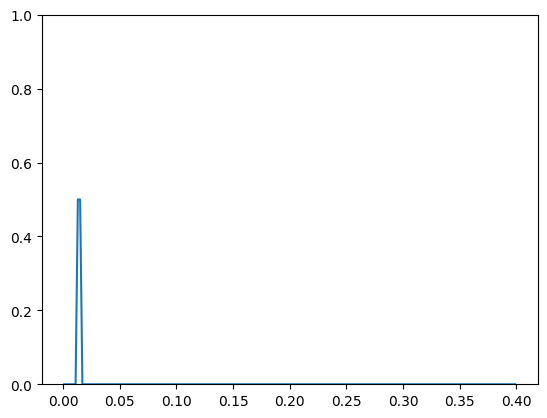

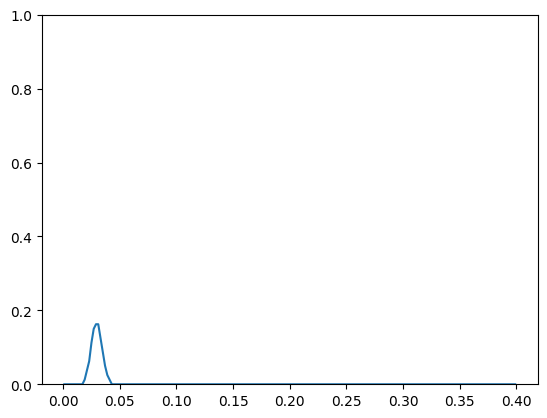

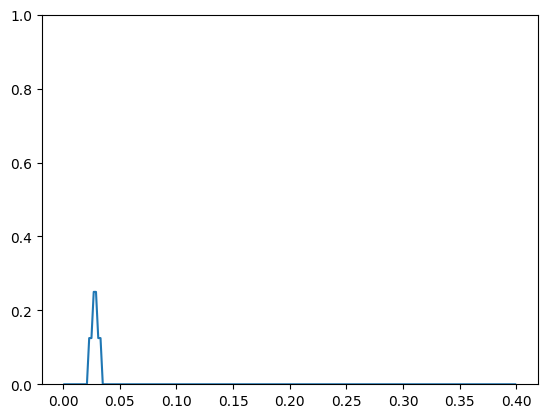

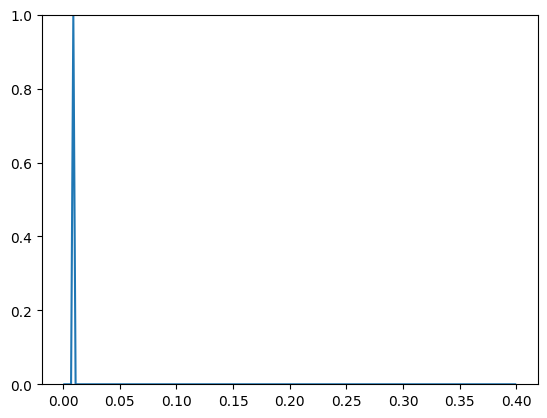

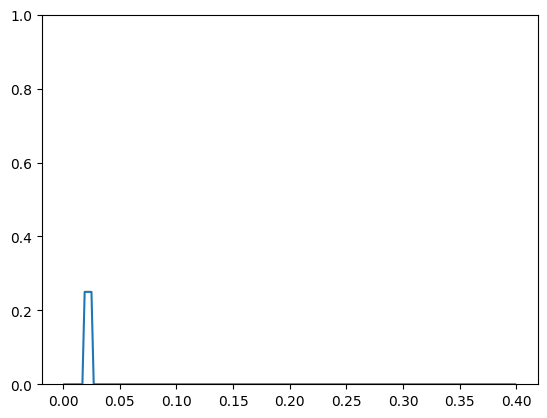

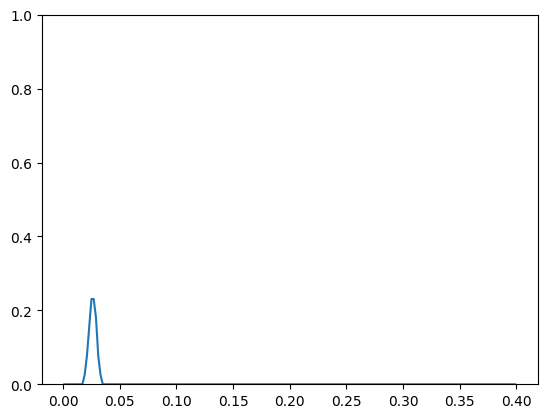

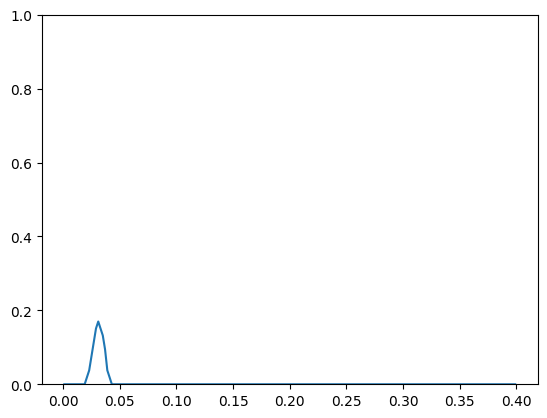

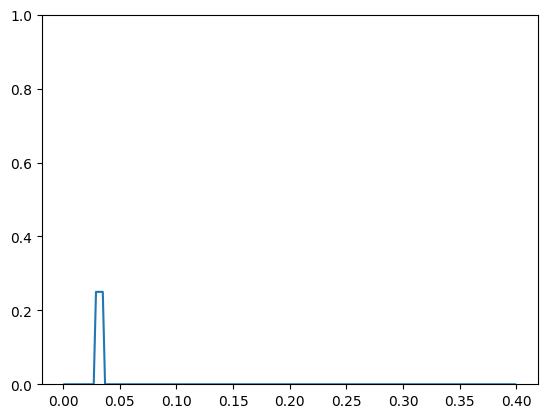

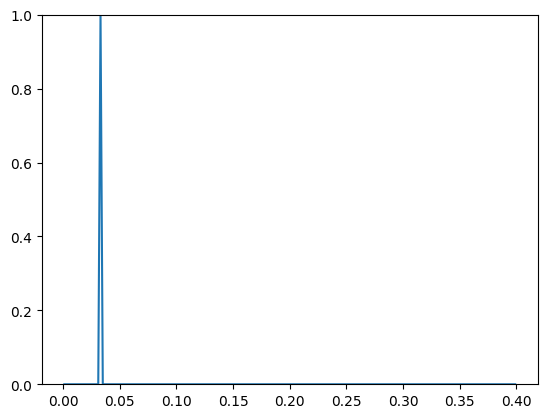

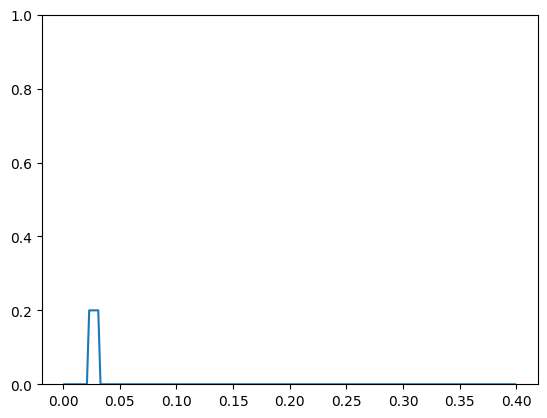

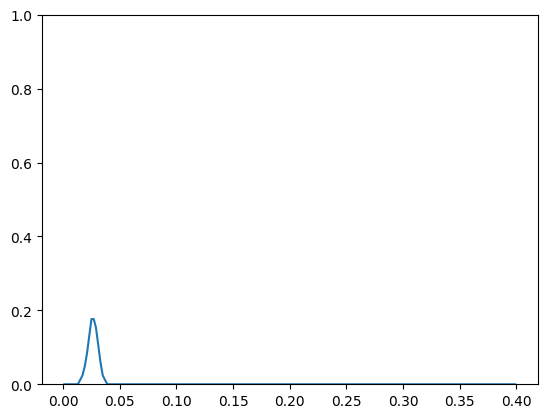

In [22]:
for network in df_epsilon['network'].unique()[1:]:
    run(network)